 ### Import Libraries

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import tifffile as tiff
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, SpatialDropout2D,concatenate, Activation, Conv2DTranspose, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import MinMaxScaler

### Load and Explore Dataset

In [2]:
def load_images_and_labels(data_path):
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')
    
    image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.png')]
    
    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        
        img = tiff.imread(os.path.join(images_path, img_file))
        
        lbl = Image.open(os.path.join(labels_path, lbl_file))
        lbl = np.array(lbl).astype(np.float32)
        
        # lbl = np.where(lbl > 0.5, 1, 0).astype(np.float32)
        
        
        images.append(img)
        labels.append(lbl)
    
    return np.array(images), np.array(labels)

data_path = r"D:\Mohamed Sheriff\Projects\Computer Vision Internship - Cellula Technologies\Water Segementation\Dataset"
images, labels = load_images_and_labels(data_path)

print(f"Loaded {len(images)} images with shape {images[0].shape} and {len(labels)} labels with shape {labels[0].shape}")
print(f"Label Unique Values: {np.unique(labels[0])}") 


Loaded 306 images with shape (128, 128, 12) and 306 labels with shape (128, 128)
Label Unique Values: [0. 1.]


In [3]:
print(f"{np.max(labels)}")

1.0


### Normalize Data

In [4]:
def normalize_image(image):
    for channel in range(image.shape[-1]):
        min = np.min(image[:,:,channel], keepdims=True)
        max = np.max(image[:,:,channel],  keepdims=True)
        if max != min:
            image[:,:,channel] = (image[:,:,channel] - min) / (max - min)
        else:
            image[:,:,channel]=0
    return image # Scale values to [0, 1]
        

images = np.array([normalize_image(img) for img in images])


#### Normalized Difference Water Index Composite $(NDWI)$

In [5]:
def ndwi(image):
    green_band = image[:, :, 2]  # Assuming Band 2 is Green
    nir_band = image[:, :, 4]    # Assuming Band 4 is NIR
    multispectral_images = (green_band - nir_band) / (green_band + nir_band + 1e-10)  # Avoid division by zero
    return multispectral_images

### Visualize Data

#### Visualize all 12 bands

Image 1 shape: (128, 128, 12)


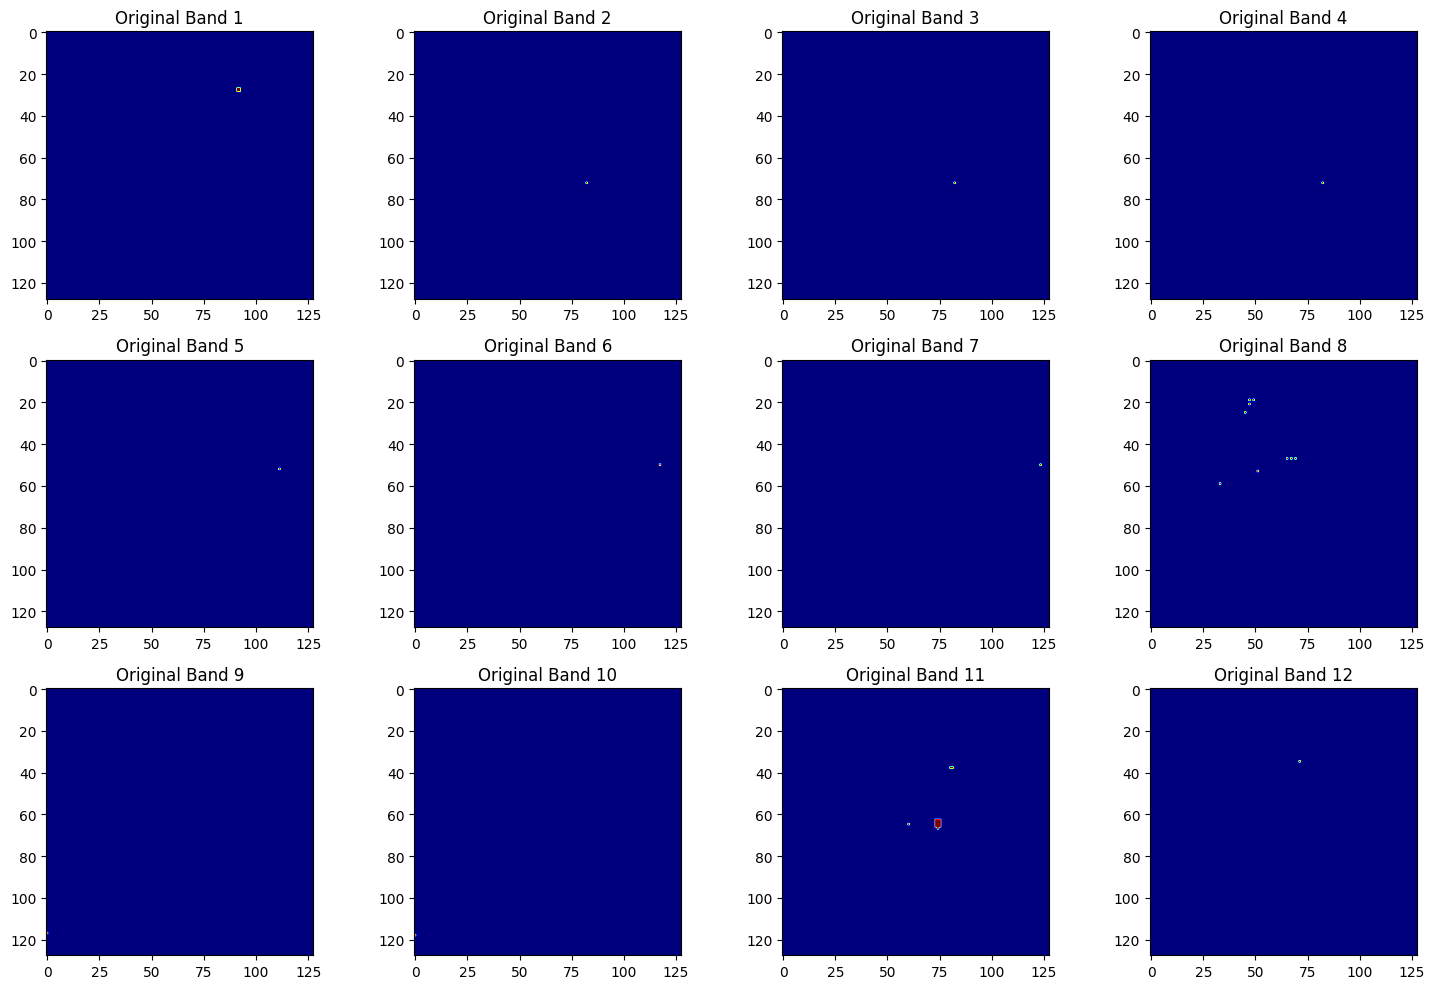

Image 2 shape: (128, 128, 12)


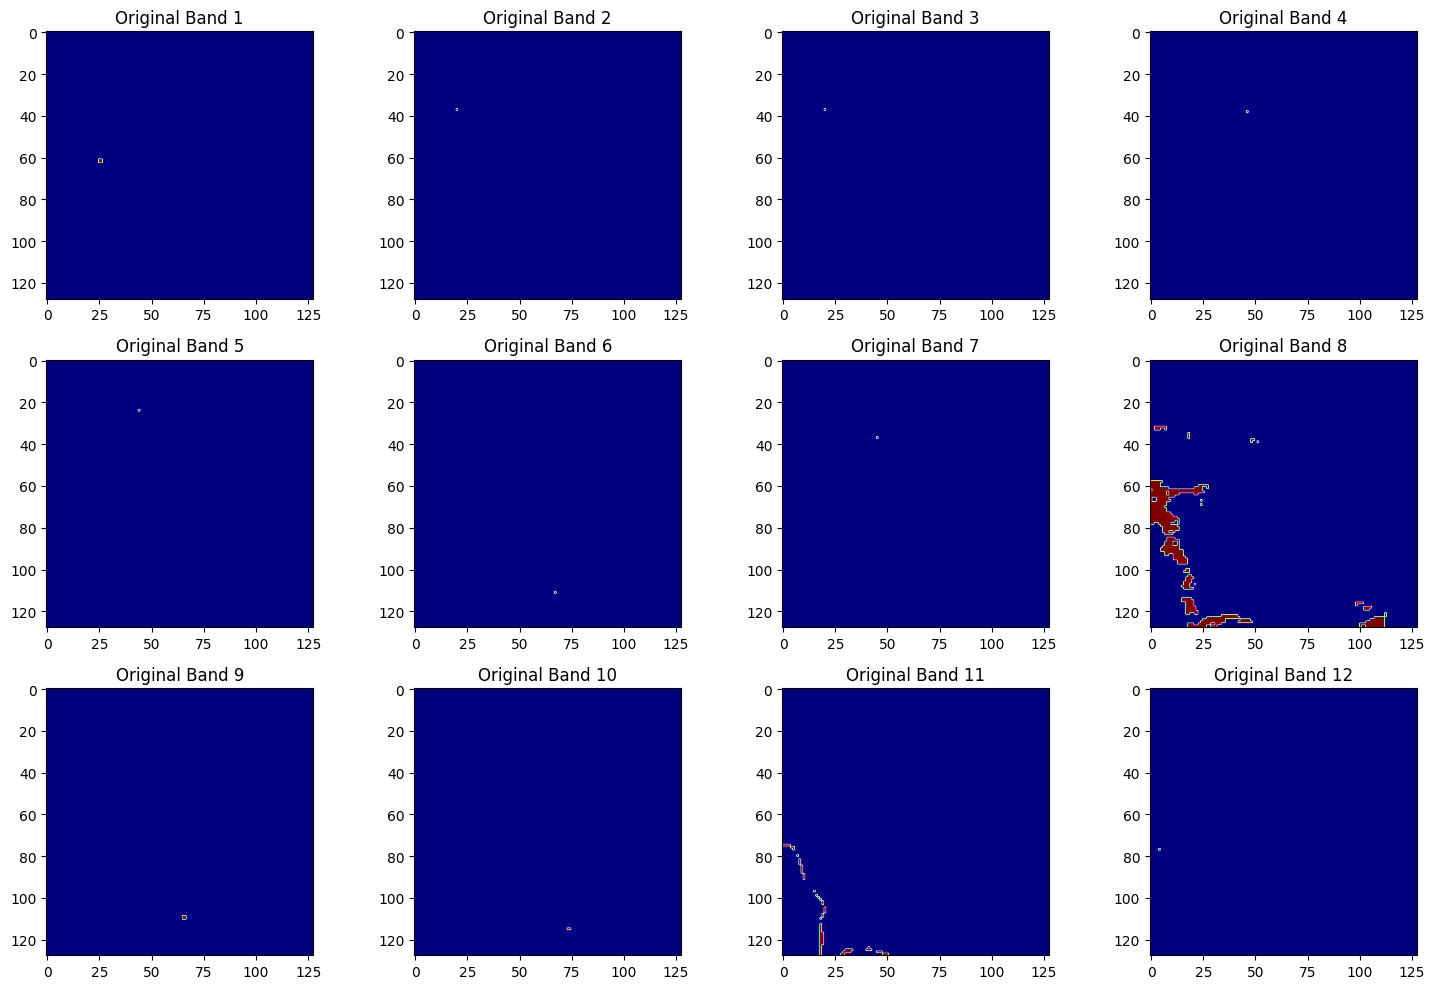

Image 3 shape: (128, 128, 12)


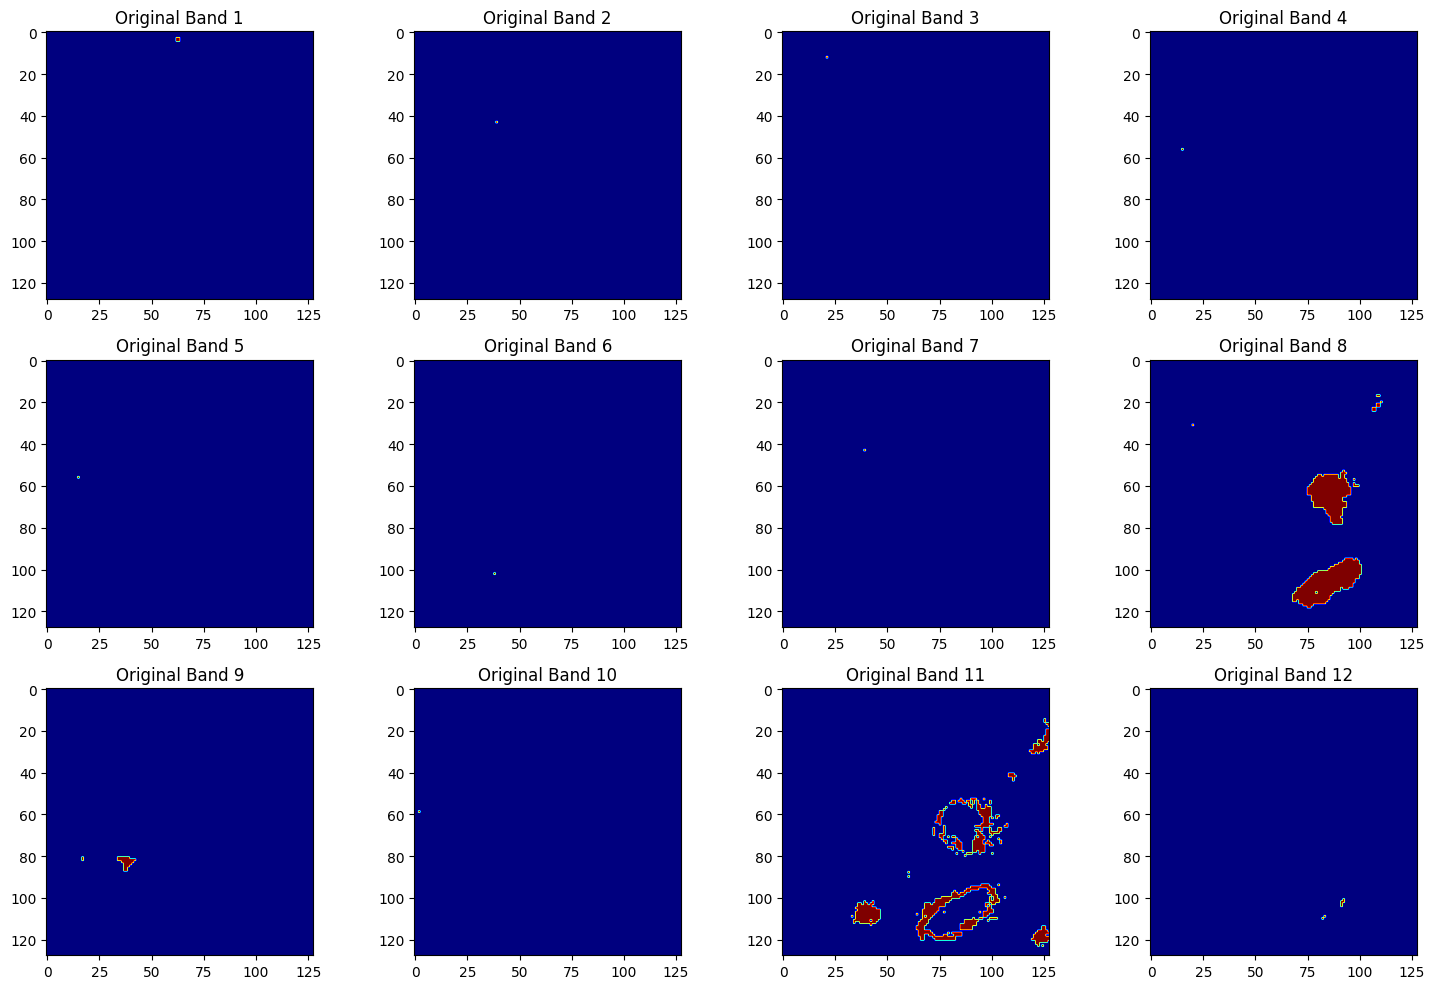

Image 4 shape: (128, 128, 12)


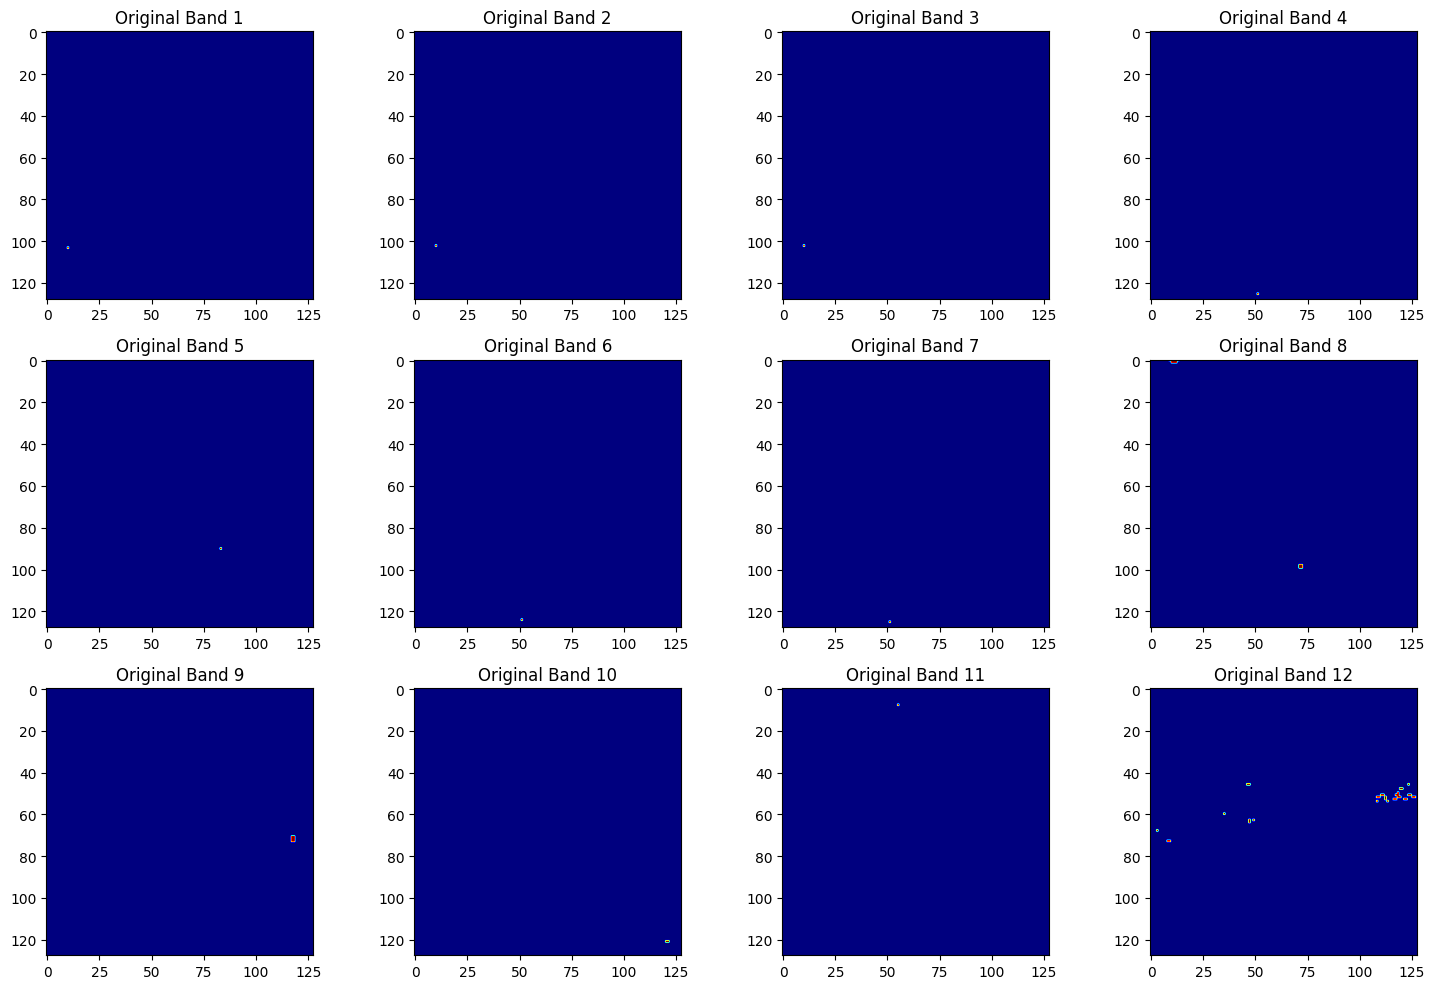

Image 5 shape: (128, 128, 12)


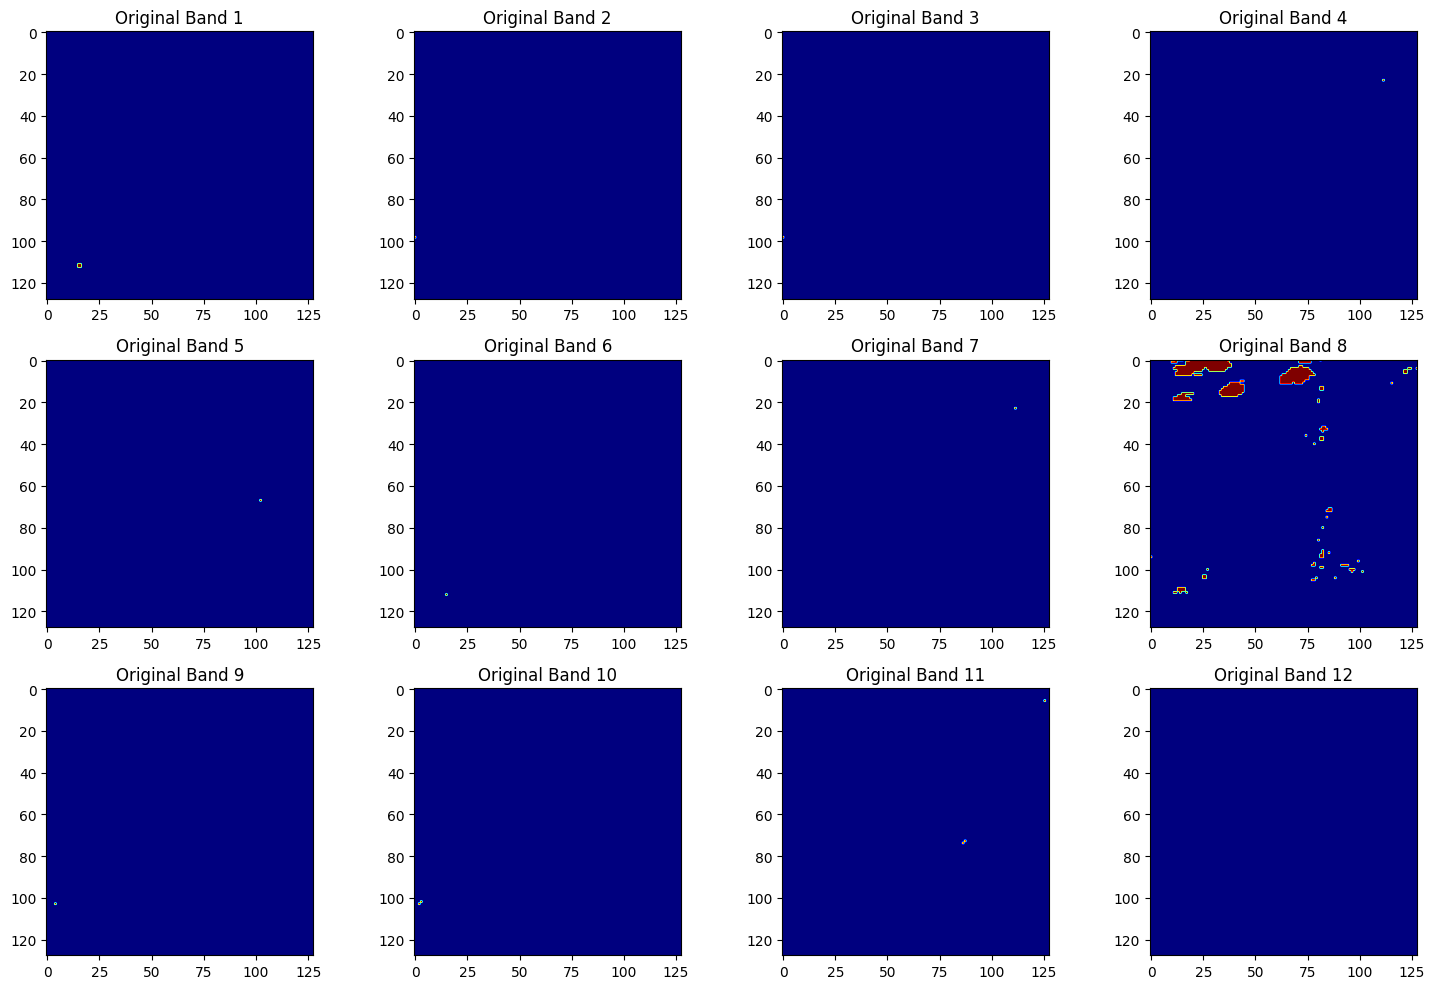

In [6]:
for i in range(5):
    print(f"Image {i+1} shape: {images[i].shape}")

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust this to ensure 12 bands are displayed in a grid
    for band in range(images[i].shape[-1]):  # Loop over each band (12 bands)
        axes[band // 4, band % 4].imshow(images[i][:, :, band], cmap='jet')
        axes[band // 4, band % 4].set_title(f'Original Band {band + 1}')
    plt.tight_layout()    
    plt.show()

#### RGB composite

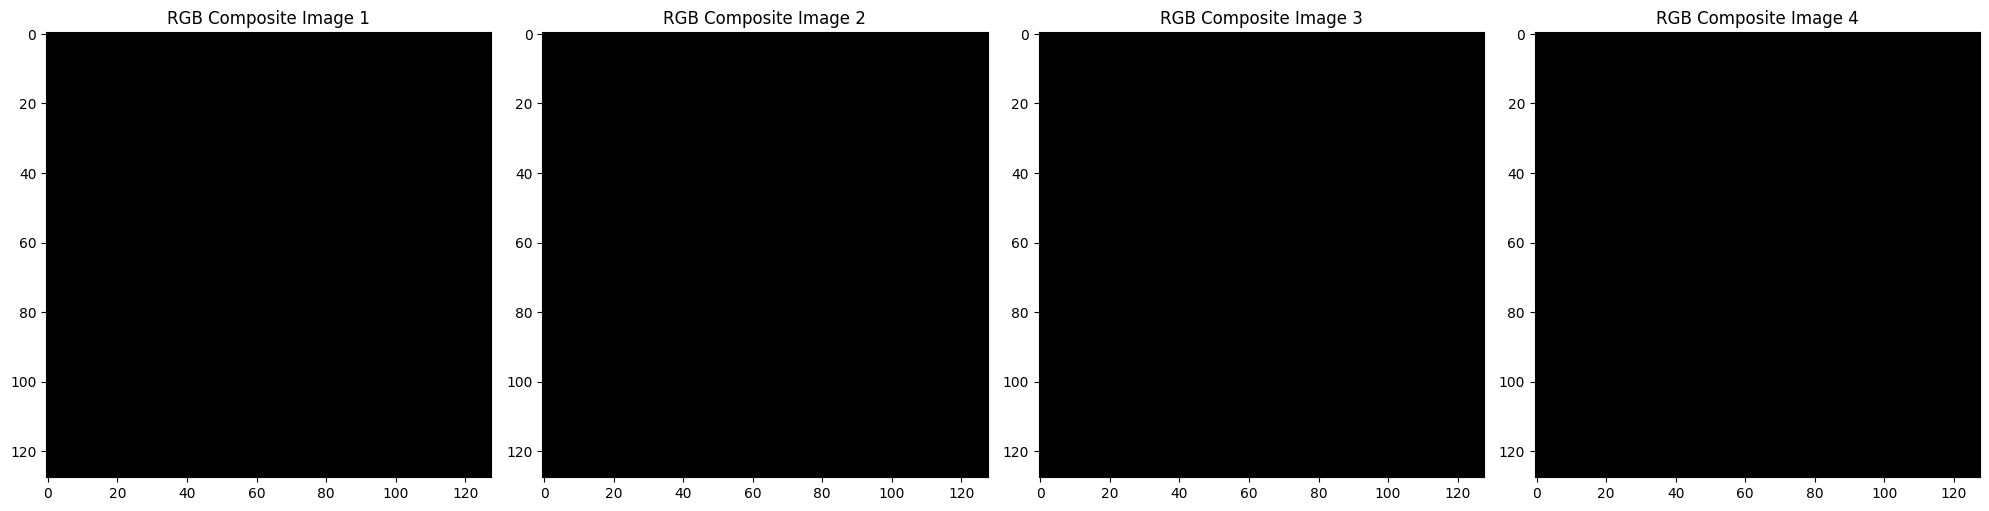

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4): 
    rgb_image = images[i][:, :, [3, 2, 1]]  # Assuming Bands 1, 2, and 3 are R, G, B
    axs[i].imshow((rgb_image * 512).astype(np.uint8))
    axs[i].set_title(f'RGB Composite Image {i+1}')
plt.tight_layout()
plt.show()

#### Visualize NDWI

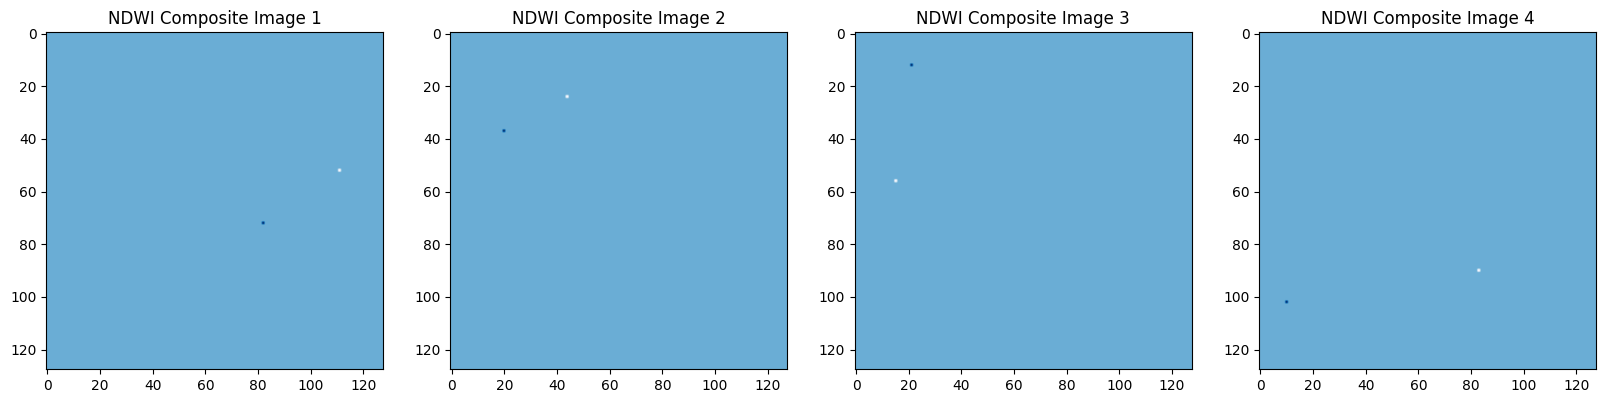

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4):  
    ndwi_image = ndwi(images[i])
    plt.figure(figsize=(5, 5))
    axs[i].imshow(ndwi_image, cmap='Blues')
    axs[i].set_title(f'NDWI Composite Image {i+1}')
plt.tight_layout()
plt.show()

#### Visualize Binary Mask for Labels

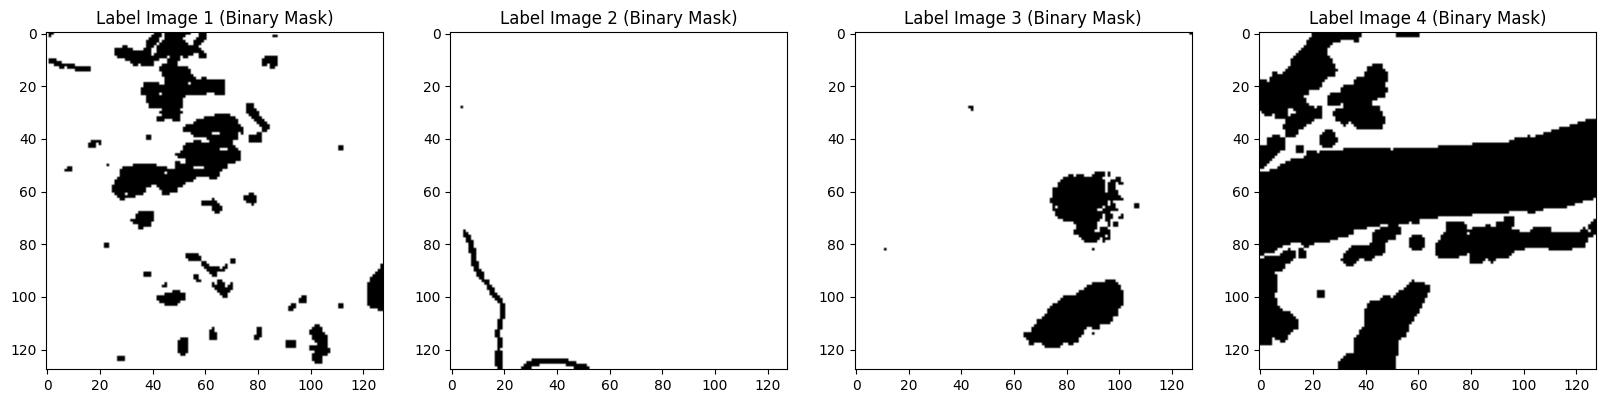

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))  

for i in range(4):  
    plt.figure(figsize=(5, 5))
    axs[i].imshow(labels[i].squeeze(), cmap='binary')
    axs[i].set_title(f'Label Image {i+1} (Binary Mask)')
plt.tight_layout()
plt.show()

### Reshape Labels for Model Training

In [10]:
labels.shape , images.shape

((306, 128, 128), (306, 128, 128, 12))

### Model Training

In [11]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=365)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size=0.5, random_state=42)


### U-Net Model Architecture

##### `Encoder`

In [12]:
def encoder_block(inputs, num_filters):

    x = Conv2D(num_filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x

##### `Decoder`

In [13]:
def decoder_block(inputs, skip_features, num_filters): 

	x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs) 
	skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2])) 
	x = tf.keras.layers.Concatenate()([x, skip_features]) 
	
	x = Conv2D(num_filters, 3, padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x) 
	x = Activation('relu')(x) 

	x = Conv2D(num_filters, 3, padding = 'same', kernel_regularizer=regularizers.l2(0.001))(x) 
	x = Activation('relu')(x) 
	
	return x

##### `U-Net Model`

In [14]:
def unet_model(input_shape=(128, 128, 12), num_classes=1):
    inputs = Input(input_shape)

    # Encoding Path
    s1 = encoder_block(inputs, 32)
    s2 = encoder_block(s1, 64)
    s3 = encoder_block(s2, 128)
    s4 = encoder_block(s3, 256)

    # Bottleneck with Dropout
    b1 = Conv2D(512, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(s4)
    b1 = Activation('relu')(b1)
    # b1 = SpatialDropout2D(0.5)(b1) 
    
    b1 = Conv2D(512, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(b1)
    b1 = Activation('relu')(b1)
    # b1 = SpatialDropout2D(0.5)(b1) 

    # Decoding Path
    s5 = decoder_block(b1, s4, 256)
    s6 = decoder_block(s5, s3, 128)
    s7 = decoder_block(s6, s2, 64)
    s8 = decoder_block(s7, s1, 32)

    # Output
    outputs = Conv2D(num_classes, 1, padding='same', activation='sigmoid')(s8)

    model = Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

if __name__ == '__main__':
    model = unet_model(input_shape=(128, 128, 12), num_classes=1)
    model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  3488        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [16]:
model_path = "D:/Mohamed Sheriff/Projects/Computer Vision Internship - Cellula Technologies/Water Segementation/Model/u-net.keras"

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True,
  )

CheckPoint = ModelCheckpoint(filepath= model_path , monitor='val_accuracy' ,save_best_only=True , mode='max')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-5
)

In [17]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    verbose=1,
    batch_size=16,
    validation_data=(x_val, y_val),
     callbacks=[early_stopping , CheckPoint, reduce_lr]
)

Epoch 1/100
16/16 [==============================] - 14s 504ms/step - loss: 3.4962 - accuracy: 0.5283 - val_loss: 3.4277 - val_accuracy: 0.6405 - lr: 1.0000e-05
Epoch 2/100
16/16 [==============================] - 4s 238ms/step - loss: 3.4391 - accuracy: 0.5915 - val_loss: 3.3917 - val_accuracy: 0.6577 - lr: 1.0000e-05
Epoch 3/100
16/16 [==============================] - 4s 264ms/step - loss: 3.3890 - accuracy: 0.6187 - val_loss: 3.3558 - val_accuracy: 0.6677 - lr: 1.0000e-05
Epoch 4/100
16/16 [==============================] - 4s 244ms/step - loss: 3.3426 - accuracy: 0.6407 - val_loss: 3.3202 - val_accuracy: 0.6716 - lr: 1.0000e-05
Epoch 5/100
16/16 [==============================] - 4s 248ms/step - loss: 3.2990 - accuracy: 0.6610 - val_loss: 3.2849 - val_accuracy: 0.6728 - lr: 1.0000e-05
Epoch 6/100
16/16 [==============================] - 4s 241ms/step - loss: 3.2611 - accuracy: 0.6714 - val_loss: 3.2501 - val_accuracy: 0.6734 - lr: 1.0000e-05
Epoch 7/100
16/16 [====================

### Evaluation 

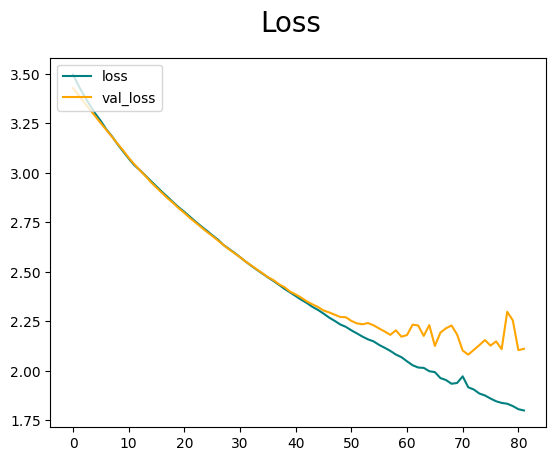

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

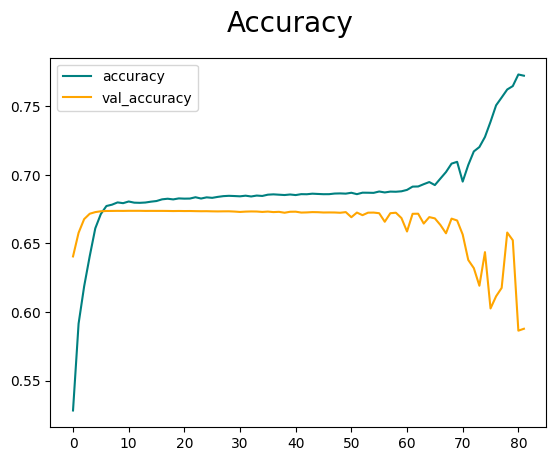

In [19]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
def visualize_predictions(images, labels, predictions, num_images=5):
    """
    Visualize the original images, predicted masks, and ground truth masks side by side.
    
    Parameters:
    - images: The original input images (e.g., multispectral).
    - labels: Ground truth binary masks.
    - predictions: Predicted binary masks from the model.
    - num_images: Number of images to visualize.
    """
    for i in range(num_images):
        # Original image (Assuming RGB composite for visualization)
        rgb_image = images[i][:, :, [1,2,3]]  # Adjust the bands for RGB composite (if applicable)
        rgb_image = (rgb_image * 255).astype(np.uint8)  # Scale for visualization

        # Check if the predictions have an extra dimension and handle accordingly
        predicted_mask = predictions[i]
        if predicted_mask.shape[-1] == 1:  # If it has an extra dimension (128, 128, 1)
            predicted_mask = np.squeeze(predicted_mask, axis=-1)  # Remove the extra dimension

        # Ground truth mask
        ground_truth = labels[i]

        # Plot side by side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(rgb_image)
        axs[0].set_title(f'Original Image {i+1}')
        axs[0].axis('off')

        axs[1].imshow(predicted_mask, cmap='gray')
        axs[1].set_title(f'Predicted Mask {i+1}')
        axs[1].axis('off')

        axs[2].imshow(ground_truth, cmap='gray')
        axs[2].set_title(f'Ground Truth Mask {i+1}')
        axs[2].axis('off')

        plt.show()

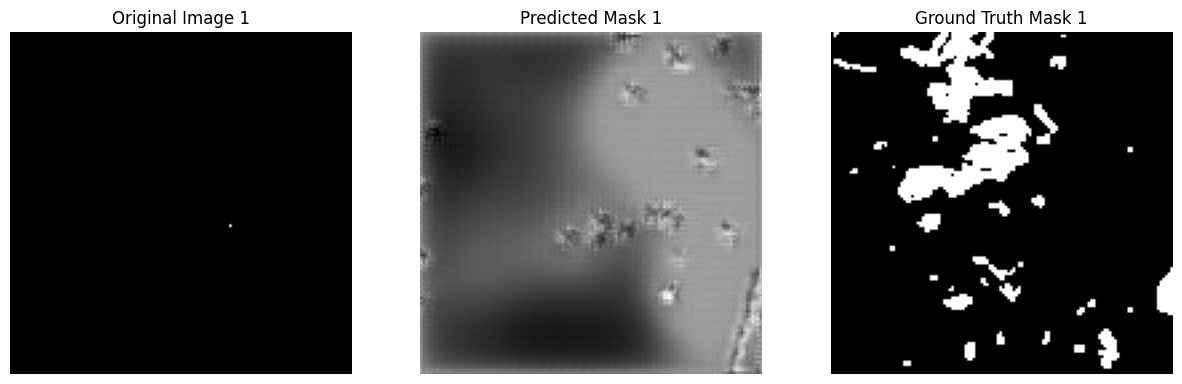

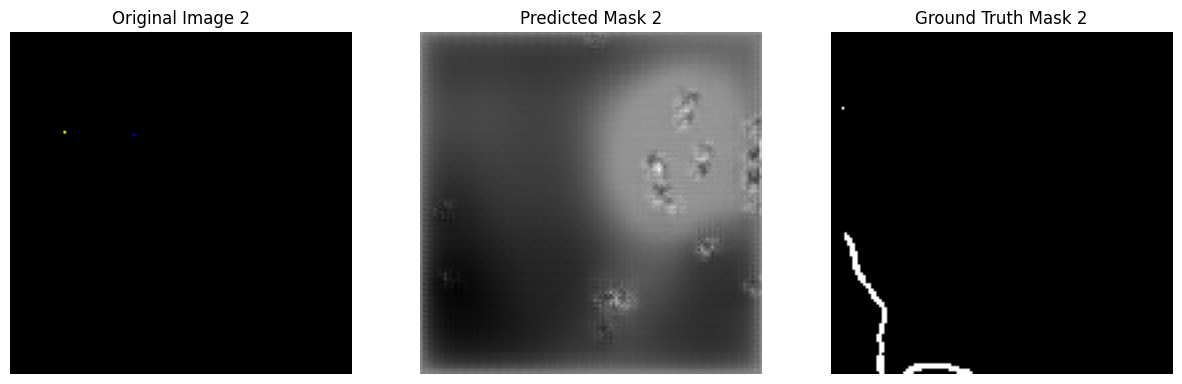

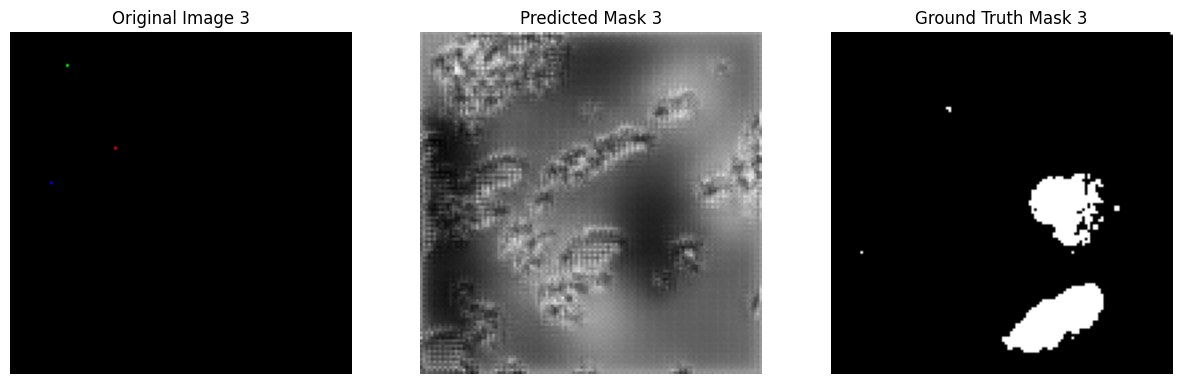

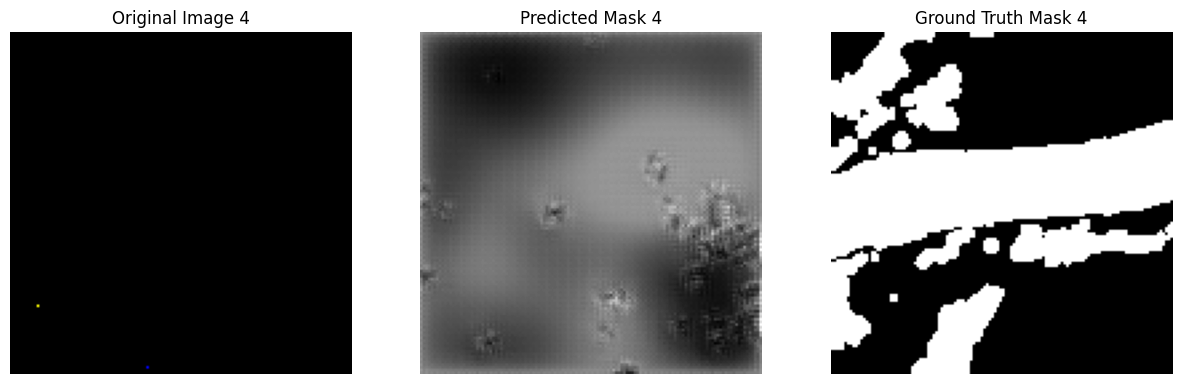

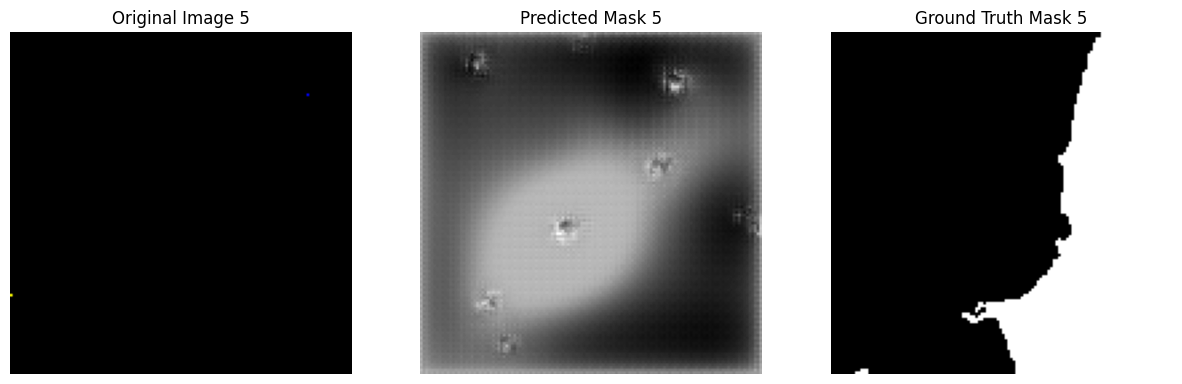

In [37]:
visualize_predictions(images, labels, y_pred, num_images=5)